## FasterRCNN

In [29]:
# Importing libraries

import os
import base64
import numpy as np
import re
import random
import json
import spacy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import operator
import seaborn
import cv2
from nltk.corpus import wordnet as wn
from num2words import num2words
import csv

import torch
import logging

path_results = "/srv/data/berenice-frcnn-results/berenice-features/"
path_obj_label = "../../bottom-up-attention/data/genome/1600-400-20/objects_vocab.txt"
path_attr_label = "../../bottom-up-attention/data/genome/1600-400-20/attributes_vocab.txt"
path_r2r = "R2R/R2R_train.json"

In [2]:
def get_frcnn_results(path):
    """Gets and returns output from FasterRCNN.
    
    FRCNN returns results for these attributes for each skybox image
    in each house:
        ['img_id', 'img_h', 'img_w', 'objects_id', 'objects_conf', 
        'attrs_id', 'attrs_conf', 'num_boxes', 'boxes', 'features', 
        'cls_prob', 'classes', 'attrs']
        
    For each .npz file produced by FRCNN:
    return {
        'img_id': image_id,
        'img_h': np.size(im, 0),
        'img_w': np.size(im, 1),
        'objects_id': base64.b64encode(objects),
        'objects_conf': base64.b64encode(obj_conf),
        'attrs_id': base64.b64encode(attr),
        'attrs_conf': base64.b64encode(attr_conf),
        'num_boxes': len(keep_boxes),
        'boxes': base64.b64encode(cls_boxes[keep_boxes]),
        'features': base64.b64encode(pool5[keep_boxes]),
        'cls_prob': base64.b64encode(cls_prob[keep_boxes]),
        'classes': base64.b64encode(scores[keep_boxes]),
        'attrs': base64.b64encode(attr_scores[keep_boxes])
    }
    
    Parameters
    ----------
    path : str
        Path to the output directory.
        
    Returns
    -------
    dict_output : dict
        A dictionary(houses) of dictionary(skybox) of list(results)
        containing specific results.
    """
    
    dict_output = {}

    for directory in os.listdir(path):
        path_directory = os.path.join(path_results, directory)
        dict_tmp = {}
        
        if directory == 'berenice-images':
            pass
        else:
            for filename in os.listdir(path_directory):

                path_filename = os.path.join(path_directory, filename)
                item = np.load(path_filename)
                
                img_id = item['img_id']
                num_boxes = item['num_boxes']
                boxes = np.frombuffer(base64.b64decode(item['boxes']), dtype=np.float32).reshape(int(num_boxes), 4)
                objects_id = np.frombuffer(base64.b64decode(item['objects_id']), dtype=np.int64)
                objects_conf = np.frombuffer(base64.b64decode(item['objects_conf']), dtype=np.float32)
                attrs_id = np.frombuffer(base64.b64decode(item['attrs_id']), dtype=np.int64)
                attrs_conf = np.frombuffer(base64.b64decode(item['attrs_conf']), dtype=np.float32)
                """
                img_h = item['img_h']
                img_w = item['img_w']
                features = np.frombuffer(base64.b64decode(item['features']), dtype=np.float32).reshape(int(num_boxes), 2048)
                cls_prob = np.frombuffer(base64.b64decode(item['cls_prob']), dtype=np.float32).reshape(int(num_boxes), 1601)
                cls_scores = np.frombuffer(base64.b64decode(item['classes']), dtype=np.float32).reshape(int(num_boxes), -1)
                attr_scores = np.frombuffer(base64.b64decode(item['attrs']), dtype=np.float32).reshape(int(num_boxes), -1)
                """
                
                dict_tmp[str(img_id)] = [list(objects_id),list(objects_conf),list(attrs_id),list(attrs_conf),boxes]

            dict_output[directory] = dict_tmp

    return dict_output

In [3]:
frcnn_results = get_frcnn_results(path_results)

In [4]:
def test_values(dict_frcnn):
    
    obj_attr_to_show = []
    
    for house, values in dict_frcnn.items():
        dict_tmp = {}
        
        for img_id, (obj_id,obj_conf,attr_id,attr_conf,boxes) in values.items():
            
            obj_attr_to_show.append([house,img_id,obj_id,obj_conf,attr_id,attr_conf,boxes])
    
    return obj_attr_to_show
obj_to_visualize = test_values(frcnn_results)

In [5]:
def get_label(path_obj, path_attr):
    """Gets and returns vocabulary from FasterRCNN.
    
    Parameters
    ----------
    path_obj : str
        Path to the object vocabulary text file.
    path_attr : str
        Path to the attribute vocabulary text file.
        
    Returns
    -------
    obj_txt : list
        A list of objects.
    attr_txt : list
        A list of attributes.
    """
    
    with open(path_obj) as obj_f:
        obj_txt = obj_f.read().splitlines()
        obj_f.close()

    with open(path_attr) as attr_f:
        attr_txt = attr_f.read().splitlines()
        attr_f.close()
        
    return obj_txt, attr_txt

Object label: floor 0.35 %, attribute: wooden 0.22 %
Object label: drawer 0.32 %, attribute: open 0.08 %
Object label: building 0.31 %, attribute: wooden 0.13 %
Object label: wood 0.31 %, attribute: wooden 0.2 %


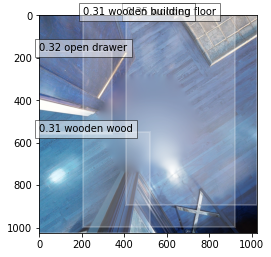

In [6]:
   def show_img_obj(list_to_see):
    """Displays an image and its overlapping bounding boxes.
    
    Parameters
    ----------
    house : str
        Scan (house) ID.
    img_id : str
        Skybox (image) ID.
    obj_id : int
        Integer value of object predicted by FRCNN.
    obj_conf : list
        Confidence score of overlapping objects.
    boxes : list
        Bounding box values of overlapping objects.
    iou : float
        Intersection Over Union score.
    """
    
    item = random.choice(list_to_see)
    house,img_id,obj_id,obj_conf,attr_id,attr_conf,boxes = item[0],item[1],item[2],item[3],item[4],item[5],item[6]

    path_house = '/srv/data/guslegbe/matterport3d/v1/scans/'
    full_path = path_house + house + '/matterport_skybox_images/' + img_id + '.jpg'
    im = cv2.imread(full_path)
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    
    for idx, obj in enumerate(obj_id):
        
        if type(obj) == str:
            attr = attr_id[idx]
        else:
            obj_voca, attr_voca = get_label(path_obj_label, path_attr_label)
            obj = obj_voca[int(obj_id[idx])]
            attr = attr_voca[int(attr_id[idx])]
            
        if obj_conf[idx] < 0.4 and obj_conf[idx] > 0.3:    
        
            print("Object label:",obj,round(obj_conf[idx], 2),"%, attribute:",attr,round(attr_conf[idx], 2),"%")

            bbox0 = boxes[idx]
            plt.gca().add_patch(plt.Rectangle((bbox0[0],bbox0[1]),
                                             bbox0[2] - bbox0[0],
                                             bbox0[3] - bbox0[1],
                                             fill=True,
                                             linewidth=2,
                                             color='white',
                                             alpha=0.2)
                               )
            plt.gca().text(bbox0[0], bbox0[1] - 2,
                           '%s %s %s' % (round(obj_conf[idx], 2),attr,obj),
                            bbox=dict(facecolor='white',alpha=0.5),
                            fontsize=10,
                            color='black')

show_img_obj(obj_to_visualize)

- Object label: grass 0.34 %, attribute: green 0.18 %
- Object label: water 0.32 %, attribute: distant 0.07 %
- Object label: distance 0.31 %, attribute: distant 0.03 %
- Object label: tree 0.31 %, attribute: green 0.18 %
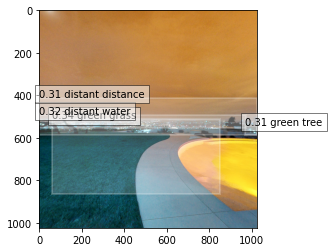

In [7]:
# https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # compute if a bounding box is inside an other
    if interArea == boxAArea or interArea == boxBArea:
        iou = 0.5
    elif (boxAArea - interArea) < 10000:
        iou = 0.5
    elif (boxBArea - interArea) < 10000:
        iou = 0.5
    
    # return the intersection over union value
    return iou

In [8]:
def process_frcnn_output(dict_frcnn):
    """Removes duplicates, confidence scores below 0.7 and maps labels
    to frcnn outputs.
    
    Parameters
    ----------
    dict_frcnn : dict
        A dictionary(houses) of dictionary(skybox) of list(results)
        containing results from frcnn.
        
    Returns
    -------
    dict_output : dict
        A dictionary(houses) of dictionary(skybox) of list(results)
        containing specific labeled results from frcnn.
    bb_to_show : list
        List of list of images with a certain proportion of Intersection
        Over Union between two objects.
    """
    
    obj_voca, attr_voca = get_label(path_obj_label, path_attr_label)
    dict_output = {}
    ious = []
    bb_to_show = []
    
    for house, values in dict_frcnn.items():
        dict_tmp = {}
        
        for img_id, (obj_id,obj_conf,attr_id,attr_conf,boxes) in values.items():
            
            noun_phrase = []
            
            # Checks for duplicates
            if len(obj_id) != len(set(obj_id)):
                tmp_remove = []
                for i, current_ele in enumerate(obj_id):
                    if obj_id[i+1:]:
                        for j, next_ele in enumerate(obj_id[i+1:]):
                            
                            # If it is the same object
                            if next_ele == current_ele:
                                
                                # Computes overlapping
                                iou = bb_intersection_over_union(boxes[i],boxes[i+1+j])
                                ious.append(iou)
                                
                                # Gets object with lowest confidence score
                                if iou >= 0.3:
                                    
                                    # Maybe not necessary ?
                                    if obj_conf[i] > 0.3 and obj_conf[i+1+j] > 0.3:
                                        if obj_conf[i] < obj_conf[i+1+j]:
                                            tmp_remove.append(i)
                                        else:
                                            tmp_remove.append(i+1+j)
                                        
                                        bb_to_show.append([house,img_id,obj_id[i],[obj_conf[i],obj_conf[i+1+j]],[boxes[i],boxes[i+1+j]],iou])
                                        
                if tmp_remove:
                    tmp_remove = list(sorted(list(set(tmp_remove)),reverse=True))
                    # Removes duplicated object
                    for idx in tmp_remove:
                        del obj_id[idx]
                        del obj_conf[idx]
                        del attr_id[idx]
                        del attr_conf[idx]
            
            # We DO NOT remove items when their confidence score is below 0.7
            # Instead, we keep objects with confidence score above 0.3
            # Checks confidence score for object
            for conf_o in obj_conf[:]:
                idx_o = obj_conf.index(conf_o)
                
                if conf_o < 0.3:
                #if conf_o < 0.7:
                    del obj_id[idx_o]
                    del obj_conf[idx_o]
                    del attr_id[idx_o]
                    del attr_conf[idx_o]
                else:
                    
                    # For unknown reasons, sometimes the output int object is
                    # already labeled as a string (probably remembering old values?)
                    if type(obj_id[idx_o]) is str:
                        pass
                    else:
                        obj_id[idx_o] = obj_voca[int(obj_id[idx_o])]
                    
                    # We DO NOT remove attributes of objects with confidence score below 0.7
                    if type(attr_conf[idx_o]) is str:
                        attr_id[idx_o] = ""
                        attr_conf[idx_o] = ""
                    #elif attr_conf[idx_o] < 0.7:
                    #    attr_id[idx_o] = ""
                    #    attr_conf[idx_o] = ""
                    else:
                        # Same problem with already labeled values?
                        if type(attr_id[idx_o]) is str:
                            pass
                        else:
                            attr_id[idx_o] = attr_voca[int(attr_id[idx_o])]
                    
                    noun_phrase.append([attr_id[idx_o],obj_id[idx_o]])

            dict_tmp[img_id] = noun_phrase
            
        dict_output[house] = dict_tmp
    
    print("Highest iou:",max(ious))
    
    return dict_output, bb_to_show

processed_frcnn, list_to_visualize = process_frcnn_output(frcnn_results)

Highest iou: 0.6998079205515374


Score iou: 37.0138478666075 %
Object label: wall


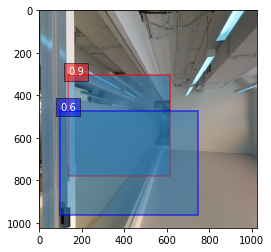

In [9]:
def show_all(list_visa):
    """Gets a random image containing an IOU >= 0.5 between two objects,
    calls function to display image and bounding boxes.
    
    Parameters
    ----------
    list_visa : list
        List of list of images with a certain proportion of Intersection
        Over Union between two objects.
    """
    
    item = random.choice(list_visa)
    if item[5] < 0.4:
        show_img(item[0],item[1],item[2],item[3],item[4],item[5])
    else:
        show_all(list_visa)
        
def show_img(house,img_id,obj_id,obj_conf,boxes,iou):
    """Displays an image and its overlapping bounding boxes.
    
    Parameters
    ----------
    house : str
        Scan (house) ID.
    img_id : str
        Skybox (image) ID.
    obj_id : int
        Integer value of object predicted by FRCNN.
    obj_conf : list
        Confidence score of overlapping objects.
    boxes : list
        Bounding box values of overlapping objects.
    iou : float
        Intersection Over Union score.
    """

    path_house = '/srv/data/guslegbe/matterport3d/v1/scans/'
    full_path = path_house + house + '/matterport_skybox_images/' + img_id + '.jpg'
    im = cv2.imread(full_path)
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    
    if type(obj_id) == str:
        print("iou:",iou,obj_id)
        iou2 = bb_intersection_over_union(boxes[0],boxes[1])
    else:
        obj_voca, attr_voca = get_label(path_obj_label, path_attr_label)
        print("Score iou:",iou*100,"%\nObject label:",obj_voca[int(obj_id)])
    
    bbox0 = boxes[0]
    plt.gca().add_patch(plt.Rectangle((bbox0[0],bbox0[1]),
                                     bbox0[2] - bbox0[0],
                                     bbox0[3] - bbox0[1],
                                     fill=True,
                                     edgecolor='red',
                                     linewidth=2,
                                     alpha=0.5)
                       )
    plt.gca().text(bbox0[0], bbox0[1] - 2,
                   '%s' % (round(obj_conf[0], 2)),
                    bbox=dict(facecolor='red',alpha=0.5),
                    fontsize=10,
                    color='white')
    
    bbox1 = boxes[1]
    plt.gca().add_patch(plt.Rectangle((bbox1[0],bbox1[1]),
                                     bbox1[2] - bbox1[0],
                                     bbox1[3] - bbox1[1],
                                     fill=True,
                                     edgecolor='blue',
                                     linewidth=2,
                                     alpha=0.5)
                       )
    plt.gca().text(bbox1[0], bbox1[1] - 2,
                   '%s' % (round(obj_conf[1], 2)),
                    bbox=dict(facecolor='blue',alpha=0.5),
                    fontsize=10,
                    color='white')

show_all(list_to_visualize)

Score iou: 51.680516667688906 %

Object label: wall

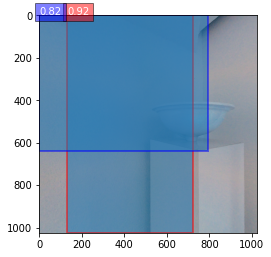

In [10]:
def get_nouns(path):
    """Gets and returns instructions from the R2R dataset.
    
    Parameters
    ----------
    path : str
        Path to the R2R json file.
        
    Returns
    -------
    dict_nouns : dict
        A dictionary of noun values from R2R dataset.
    dict_nps : dict
        A dictionary of noun phrases values from R2R dataset.
    """

    json_data = []
    with open(path) as json_file:
        json_data = json.load(json_file)

    
    nlp = spacy.load("en_core_web_sm")
    dict_nouns = {}
    dict_np = {}
    
    for item in json_data:
        
        nouns = []
        nps = []
        clean_nouns = []
        
        path_id = item['path_id']
        scan = item['scan']
        path = item['path']
        
        for sent in item['instructions']:
            doc = nlp(sent)
            
            for token in doc:
                if token.pos_ == "NOUN":
                    nouns.append(str(token))
            
            for noun_chunk in doc.noun_chunks:
                nps.append(str(noun_chunk.text))
                
        # Removing unnecessary whitespaces
        nps = [item.strip() for item in nps]
        
        # Removing punctuation and lowering text
        nouns = [re.sub("[/|\.|\,|#|\"|\']", "", item.lower()) for item in nouns]
        nps = [re.sub("[/|\.|\,|#|\"|\']", "", item.lower()) for item in nps]
        
        # Removing plural form for most of the nouns
        # to get more accurate frequency amoung nouns
        exceptions = ["christmas","table-tennis","tennis","canvas","stairs","upstairs","downstairs","ladies","towards","glasses","cactus","switches","paris","bookshelves","shelves","couches","benches"]
        for word in nouns:
            if word[-1] == "s":
                # Exception for : type errors (e.g. "s")
                #                 word with two "s" (e.g. "glass")
                #                 words part of exceptions (e.g. "tennis")
                if len(word) == 1 or word[-2] == "s" or word in exceptions:
                    pass
                else :
                    word = word[:-1]
            clean_nouns.append(word)
        
        dict_nouns.setdefault(scan,[]).append({path_id:[path,clean_nouns]})
        dict_np.setdefault(scan,[]).append({path_id:[path,nps]})
        
    return dict_nouns, dict_np

r2r_n, r2r_np = get_nouns(path_r2r)
%store r2r_n
%store r2r_np

Stored 'r2r_n' (dict)
Stored 'r2r_np' (dict)


In [11]:
%store -r r2r_n
r2r_n.items()

dict_items([('VLzqgDo317F', [{6250: [['af3af33b0120469c9a00daa0d0b36799', '5be145994f974347850a48cecd04cdcd', '79aedad1206b4eea9c4b639ea2182eb7', '1c91ed40af2246f2b126dd0f661970df', '385019f5d018430fa233d483b253076c', 'fd263d778b534f798d0e1ae48886e5f3'], ['flight', 'stairs', 'landing', 'column', 'turn', 'step', 'landing', 'stairs', 'stairs']]}, {6447: [['1da0c5eb43fd4722a5f7f5c7d4e18b4e', 'fd433ad8502149ec849c4c51bb989e4a', 'dd6b2993f882400ab51f9e8c38148b7a', '79aedad1206b4eea9c4b639ea2182eb7', '1c91ed40af2246f2b126dd0f661970df', '385019f5d018430fa233d483b253076c', 'fd263d778b534f798d0e1ae48886e5f3'], ['stairs', 'stairs', 'landing', 'room', 'stairs', 'landing', 'banister', 'rope', 'line', 'stairs', 'bottom', 'landing']]}, {3158: [['e25b3ee74de846c18029e06899faf471', '057976101e4f4f04b99391f81aa9c1b8', '807009de2d6c43bf857a9250dc76f8be', '56cf724d00bd469c8c4b80ad9ffa68dd', '813bb8880cdf4a24b48d97af1b4443a2', 'f490656d21134ff79be372d985ad965c', 'fd263d778b534f798d0e1ae48886e5f3'], ['tabl

In [12]:
%store -r r2r_np
r2r_np["VLzqgDo317F"]

[{6250: [['af3af33b0120469c9a00daa0d0b36799',
    '5be145994f974347850a48cecd04cdcd',
    '79aedad1206b4eea9c4b639ea2182eb7',
    '1c91ed40af2246f2b126dd0f661970df',
    '385019f5d018430fa233d483b253076c',
    'fd263d778b534f798d0e1ae48886e5f3'],
   ['one flight',
    'stairs',
    'the landing',
    'the columns',
    'a sharp turn',
    'the steps',
    'the landing',
    'the stairs',
    'the stairs']]},
 {6447: [['1da0c5eb43fd4722a5f7f5c7d4e18b4e',
    'fd433ad8502149ec849c4c51bb989e4a',
    'dd6b2993f882400ab51f9e8c38148b7a',
    '79aedad1206b4eea9c4b639ea2182eb7',
    '1c91ed40af2246f2b126dd0f661970df',
    '385019f5d018430fa233d483b253076c',
    'fd263d778b534f798d0e1ae48886e5f3'],
   ['the stairs',
    'the stairs',
    'the landing',
    'the room',
    'the stairs',
    'the first landing',
    'the banister',
    'the rope line',
    'the stairs',
    'the bottom',
    'the first landing']]},
 {3158: [['e25b3ee74de846c18029e06899faf471',
    '057976101e4f4f04b99391f81aa9c1b

In [20]:
def noun_to_wordnet(dataset):
    """Produces wordnet form of nouns from dataset.
    
    Parameters
    ----------
    dataset : dict
        A dictionary of nouns from R2R dataset.
    """
    
    nouns = []
    sep = ","
    
    for house, val in dataset.items():
        for skybox, frcnn_np in val.items():
            for pair in frcnn_np:
                # Handle "microwave,microwave oven"
                if sep in pair[1]:
                    pair[1] = pair[1].split(sep, 1)[0]
                if pair[0]:
                    if str(pair[0]+' '+pair[1]) not in nouns:
                        nouns.append(str(pair[0]+' '+pair[1]))
                else:
                    if str(pair[1]) not in nouns:
                        nouns.append(str(pair[1]))
    
    #dataset = sorted(list(set([item for sublist in nouns for item in sublist.split()])))
    dataset = sorted(list([item for sublist in nouns for item in sublist.split()]))
    wn_nouns = []
    
    for token in dataset:
        w_synset = wn.synsets(token)
        if w_synset: 
            wn_nouns.append(str(w_synset[0])[8:-2])
    
    #wn_nouns = list(set(wn_nouns))
    wn_nouns = list(wn_nouns)
    
    with open("wordnet_frcnn.txt", 'w') as f:
        for w in wn_nouns:
            f.write(w)
            f.write("\n")
        f.close()
        
    return nouns
    
frcnn_np_form = noun_to_wordnet(processed_frcnn)

In [14]:
def score_skybox(data_r2r,data_frcnn,ifstatement):
    """Look if objects and their attributes (from FRCNN) are mentioned
    in the noun phrases. Returns scores for each skyboxes.
    
    Parameters
    ----------
    data_r2r : dict
        A dictionary of values from R2R dataset.
    data_frcnn : dict
        A dictionary(houses) of dictionary(skybox) of list(results)
        containing specific labeled results from frcnn.
        
    Returns
    -------
    house_pathid : dict
        A dictionary(houses) of dictionary(pathid) of list(noun phrases) and
        dictionary(skybox) of list(attributes,objects).
    scores_skybox : dict
        Object scores for each skybox.
    """

    house_pathid = {}
    scores_skybox = {}

    for house, v_item in data_r2r.items():
        
        for itm in v_item:
        
            for pathid, (list_path, nouns) in itm.items():
                pathid_skybox = {}

                for skybox, frcnn_np in data_frcnn[house].items():
                    skybox_n_vals = {}

                    # if skybox is in list of path
                    if skybox[:-13] in list_path:

                        skybox_n_vals[skybox] = frcnn_np
                        pathid_skybox.setdefault(pathid,[nouns]).append(skybox_n_vals)

                        if ifstatement == True:
                            for pair in frcnn_np:
                                scores_skybox.setdefault(skybox[-12:-5],0)
                                
                                for n in nouns:
                                    # we look if attributes and objects are in descriptions
                                    if str(pair[0]+' '+pair[1]) in n:
                                        scores_skybox[skybox[-12:-5]] += 1
                                        nouns.remove(n)

                        elif ifstatement == False:
                            for pair in frcnn_np:
                                
                                for n in nouns:
                                    # we look if objects_id are in descriptions
                                    if pair[1] in n:
                                        # we want to know if some skybox are
                                        # more relevant than others
                                        scores_skybox.setdefault(skybox[-12:-5],0)
                                        scores_skybox[skybox[-12:-5]] += 1
                                        nouns.remove(n)

                house_pathid.setdefault(house,[]).append(pathid_skybox)
        
    return house_pathid, scores_skybox

frcnn_n, scores = score_skybox(r2r_n,processed_frcnn,False)
frcnn_np, scores_np = score_skybox(r2r_np,processed_frcnn,True)

In [15]:
print(scores)

{'skybox3': 11029, 'skybox0': 2470, 'skybox4': 10233, 'skybox5': 4320, 'skybox1': 11650, 'skybox2': 10267}


In [16]:
#with objects and attributes combined
print(scores_np)
#print(frcnn_np['ZMojNkEp431'])

{'skybox5': 154, 'skybox0': 29, 'skybox2': 671, 'skybox3': 659, 'skybox4': 632, 'skybox1': 645}


In [17]:
def show_figure(data,title):
    """Present skybox scores.
    
    Parameters
    ----------
    data : dict
        Dictionary of scores.
    title : str
        Description of output.
    """
    
    data = Counter(data)
    ratio = dict(sorted(data.items()))
    ratio_val = list(ratio.values())
    ratio_key = list(ratio.keys())
    
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title(title,fontweight="bold", size=20)
    ax.set_xlabel("Skybox", fontsize = 20)
    legend = ["Top","Back","Left","Front","Right","Bottom"]
    all_plot = seaborn.barplot(x=ratio_key, y=ratio_val, ax=ax, hue=legend, dodge=False)
    plt.show()

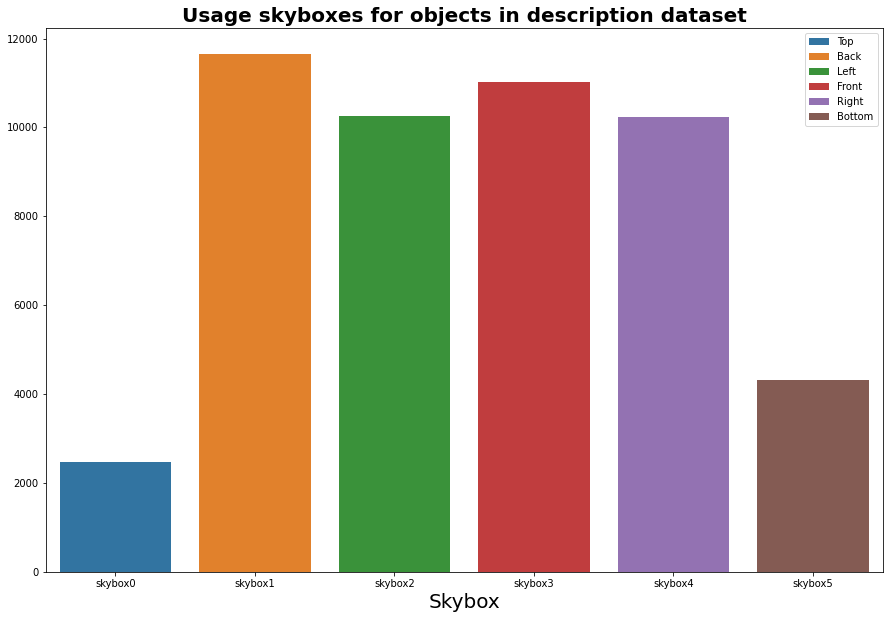

In [18]:
show_figure(scores,"Usage skyboxes for objects in description dataset")

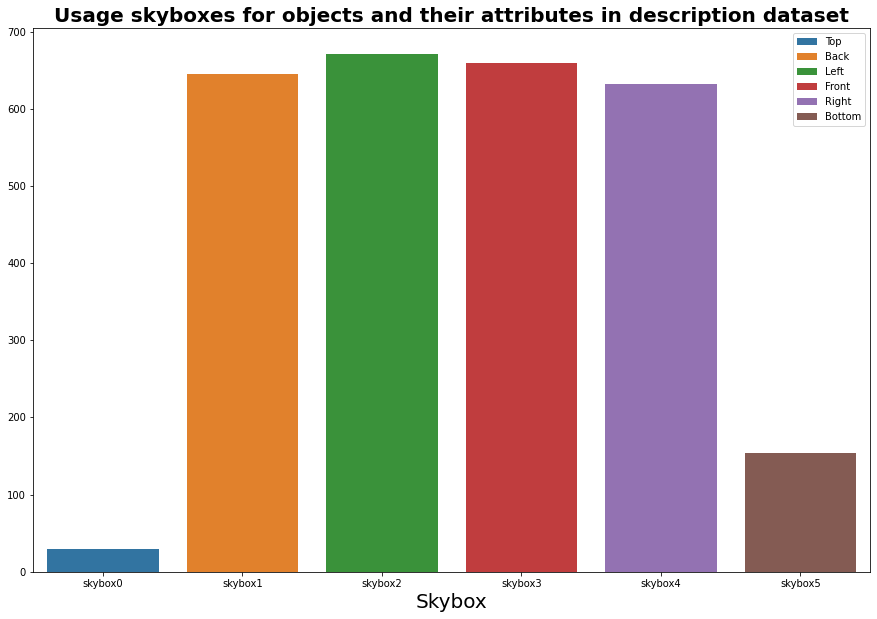

In [19]:
show_figure(scores_np,"Usage skyboxes for objects and their attributes in description dataset")

Output with all confidence scores kept
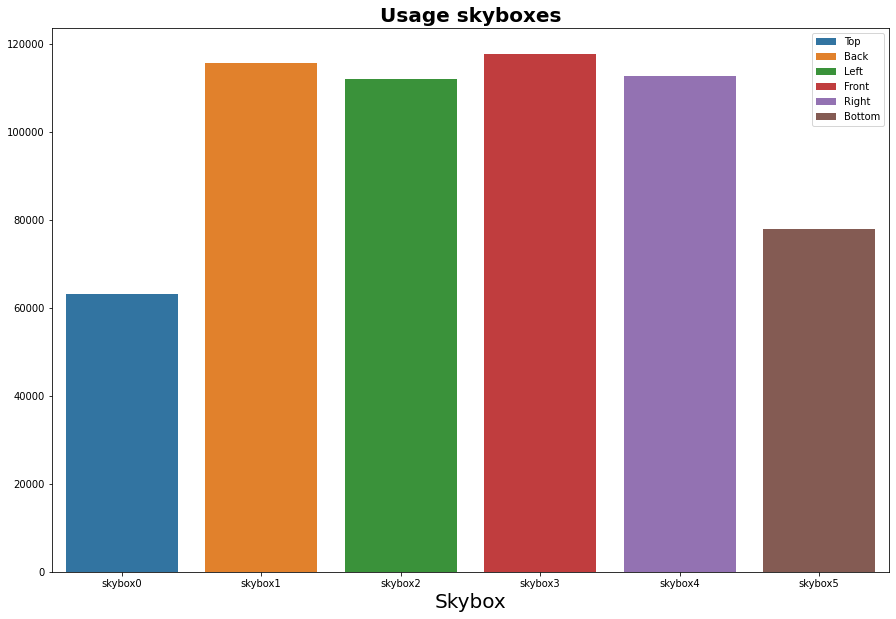

# Work in progress
- run baseline model from Peter Anderson 
    - docker local (error because of NVIDIA not found by in docker)
    - without docker local (error because of nothing, it just doesn't find MatterSim)
    - without docker MLT (error because of ld not finding libraries)
- add embeddings features in model (env.py / class R2RBatch / line 35)
- ...
- when looking for attr + obj in skybox np, no plural form taken even though nps can be plural
- preprocess np from R2R before input to embeddings ?
- coreferences (evaluate allennlp, 10% manually)
- ...
- visualization link objs + nouns ? Compute cosine similarity ?

In [35]:
# count instances of object from frcnn
# count instances of attributes from frcnn
# count instances of nouns / attributes from description

#frcnn_value and r2r_value into csv file
def frcnn_to_emb(title,data):
    list_values = []
    
    for key, val in data.items():
        for skybox, list_of_pairs in val.items():
            for pair in list_of_pairs:
                if pair[1]:
                    list_values.append(pair[0]+' '+pair[1])
                else:
                    list_values.append(pair[0])
    
    with open(title, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(list_values)
        f.close()
    
frcnn_to_emb("frcnn_emb.csv",processed_frcnn)